# TS-TCC Model Training and Evaluation

This notebook demonstrates training and evaluation of the TS-TCC (Temporal and Spatial Time-series Contrastive Learning) model on HAR datasets.

In [3]:
import sys
import os
sys.path.append('../')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import models and configurations
from src.models.tstcc import TSTCCModel, TemporalContrastiveModel, NTXentLoss, apply_augmentations
from src.data.motionsense_loader import create_windowed_time_series
from configs.motionsense_config import MotionSenseConfig

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Using device: cuda


## 1. Data Loading and Preparation

In [4]:
# Load configuration
config = MotionSenseConfig()

# Load MotionSense dataset
print("Loading MotionSense dataset...")
X_train, X_test, y_train, y_test = create_windowed_time_series(
    data_dir=config.DATA_DIR,
    num_features=config.NUM_FEATURES,
    num_act_labels=config.NUM_CLASSES,
    window_size=config.WINDOW_SIZE,
    overlap=config.OVERLAP,
    normalize=True
)

# Extract activity labels
y_train_labels = np.argmax(y_train[:, :config.NUM_CLASSES], axis=1)
y_test_labels = np.argmax(y_test[:, :config.NUM_CLASSES], axis=1)

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Number of classes: {len(np.unique(y_train_labels))}")

# Activity names
activity_names = ['downstairs', 'upstairs', 'walking', 'jogging', 'sitting', 'standing']

# Create data loaders
batch_size = 64

train_dataset = TensorDataset(
    torch.FloatTensor(X_train), 
    torch.LongTensor(y_train_labels)
)
test_dataset = TensorDataset(
    torch.FloatTensor(X_test), 
    torch.LongTensor(y_test_labels)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Loading MotionSense dataset...
使用滑动窗口参数: window_size=128, overlap=0.5
----> Data subjects information is imported.
执行数据标准化...
执行数据标准化...
生成窗口统计:
  训练集: 16579 个窗口
  测试集: 4960 个窗口
  特征形状: [N, C=12, T=128]
Train data shape: (16579, 12, 128)
Test data shape: (4960, 12, 128)
Number of classes: 6
Training batches: 259
Test batches: 78
生成窗口统计:
  训练集: 16579 个窗口
  测试集: 4960 个窗口
  特征形状: [N, C=12, T=128]
Train data shape: (16579, 12, 128)
Test data shape: (4960, 12, 128)
Number of classes: 6
Training batches: 259
Test batches: 78


## 2. Model Initialization

In [5]:
# Initialize TS-TCC model
model = TSTCCModel(
    input_channels=config.NUM_FEATURES,
    num_classes=config.NUM_CLASSES,
    mid_channels=64,
    final_out_channels=128
).to(device)

# Initialize temporal contrastive model
temporal_model = TemporalContrastiveModel(
    input_dim=128,
    hidden_dim=100,
    output_dim=50
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Temporal model parameters: {sum(p.numel() for p in temporal_model.parameters()):,}")

# Print model architecture
print("\nTS-TCC Model Architecture:")
print(model)
print("\nTemporal Contrastive Model Architecture:")
print(temporal_model)

Model parameters: 105,990
Temporal model parameters: 18,150

TS-TCC Model Architecture:
TSTCCModel(
  (encoder): TSTCCEncoder(
    (conv_block1): ConvBlock(
      (conv): Conv1d(12, 64, kernel_size=(8,), stride=(1,), padding=(4,))
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv_block2): ConvBlock(
      (conv): Conv1d(64, 64, kernel_size=(8,), stride=(1,), padding=(4,))
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv_block3): ConvBlock(
      (conv): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=(4,))
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  )
  (dropout): Dropout(p=0.35, inplace=False)
  (logits): Linear(in_features=128, out_features=6, bias=True)
)

Temporal Contrastive Model Archite

## 3. Self-Supervised Pre-training

In [6]:
# Training configuration
num_epochs = 50  # Reduced for notebook demonstration
learning_rate = 3e-4
temperature = 0.2

# Optimizer and loss function
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(temporal_model.parameters()),
    lr=learning_rate,
    weight_decay=1e-6
)

contrastive_loss_fn = NTXentLoss(temperature=temperature)

# Training loop
model.train()
temporal_model.train()

train_losses = []
epoch_losses = []

print("Starting self-supervised pre-training...")

for epoch in range(num_epochs):
    epoch_loss = 0.0
    
    # Progress bar for current epoch
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for batch_idx, (data, _) in enumerate(pbar):
        data = data.to(device)
        
        # Apply data augmentations
        augmentations = ['jitter', 'scaling', 'rotation']
        aug1, aug2 = apply_augmentations(data, augmentations)
        
        # Forward pass through main model
        _, features1 = model(aug1)
        _, features2 = model(aug2)
        
        # Forward pass through temporal contrastive model
        z1 = temporal_model(features1)
        z2 = temporal_model(features2)
        
        # Compute contrastive loss
        loss = contrastive_loss_fn(z1, z2)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Update progress bar
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}: Average Loss = {avg_loss:.4f}')

print("Self-supervised pre-training completed!")

Starting self-supervised pre-training...


Epoch 1/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 10: Average Loss = 2.5082


Epoch 11/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 20: Average Loss = 2.2893


Epoch 21/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 30: Average Loss = 2.2191


Epoch 31/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 40: Average Loss = 2.1325


Epoch 41/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 50: Average Loss = 2.1458
Self-supervised pre-training completed!


## 4. Fine-tuning for Classification

In [7]:
# Fine-tuning configuration
finetune_epochs = 25
finetune_lr = 1e-4  # Lower learning rate for fine-tuning

# New optimizer for fine-tuning (only main model)
finetune_optimizer = torch.optim.Adam(
    model.parameters(),
    lr=finetune_lr,
    weight_decay=1e-6
)

criterion = nn.CrossEntropyLoss()

# Fine-tuning loop
model.train()
finetune_losses = []
finetune_accuracies = []

print("Starting fine-tuning for classification...")

for epoch in range(finetune_epochs):
    model.train()
    epoch_loss = 0.0
    
    # Training phase
    pbar = tqdm(train_loader, desc=f'Fine-tune Epoch {epoch+1}/{finetune_epochs}')
    
    for data, labels in pbar:
        data, labels = data.to(device), labels.to(device)
        
        # Forward pass
        predictions, _ = model(data)
        loss = criterion(predictions, labels)
        
        # Backward pass
        finetune_optimizer.zero_grad()
        loss.backward()
        finetune_optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
    
    # Evaluation phase
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            predictions, _ = model(data)
            
            _, predicted = torch.max(predictions.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    avg_loss = epoch_loss / len(train_loader)
    
    finetune_losses.append(avg_loss)
    finetune_accuracies.append(accuracy)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}')

print("Fine-tuning completed!")
print(f"Final test accuracy: {finetune_accuracies[-1]:.4f}")

Starting fine-tuning for classification...



Fine-tune Epoch 1/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 2/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 3/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 4/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 5/25:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 5: Loss = 0.1471, Accuracy = 0.9700


Fine-tune Epoch 6/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 7/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 8/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 9/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 10/25:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 10: Loss = 0.0719, Accuracy = 0.9730


Fine-tune Epoch 11/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 12/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 13/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 14/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 15/25:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 15: Loss = 0.0473, Accuracy = 0.9742


Fine-tune Epoch 16/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 17/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 18/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 19/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 20/25:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 20: Loss = 0.0391, Accuracy = 0.9556


Fine-tune Epoch 21/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 22/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 23/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 24/25:   0%|          | 0/259 [00:00<?, ?it/s]

Fine-tune Epoch 25/25:   0%|          | 0/259 [00:00<?, ?it/s]

Epoch 25: Loss = 0.0294, Accuracy = 0.9589
Fine-tuning completed!
Final test accuracy: 0.9589


## 5. Model Evaluation

In [8]:
# Detailed evaluation
model.eval()
all_preds = []
all_labels = []
all_features = []

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        predictions, features = model(data)
        
        preds = torch.argmax(predictions, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_features.append(features.cpu().numpy())

all_features = np.concatenate(all_features, axis=0)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=activity_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)

Test Accuracy: 0.9589

Classification Report:
              precision    recall  f1-score   support

  downstairs       0.82      0.97      0.89       316
    upstairs       0.83      0.97      0.89       400
     walking       0.99      0.95      0.97       984
     jogging       0.97      0.97      0.97       431
     sitting       1.00      0.95      0.98      1590
    standing       0.97      0.96      0.96      1239

    accuracy                           0.96      4960
   macro avg       0.93      0.96      0.94      4960
weighted avg       0.96      0.96      0.96      4960


Confusion Matrix:
[[ 307    5    4    0    0    0]
 [   9  388    2    1    0    0]
 [   0   33  939   12    0    0]
 [  11    1    0  419    0    0]
 [   0   39    0    0 1515   36]
 [  49    2    0    0    0 1188]]


## 6. Visualization and Analysis

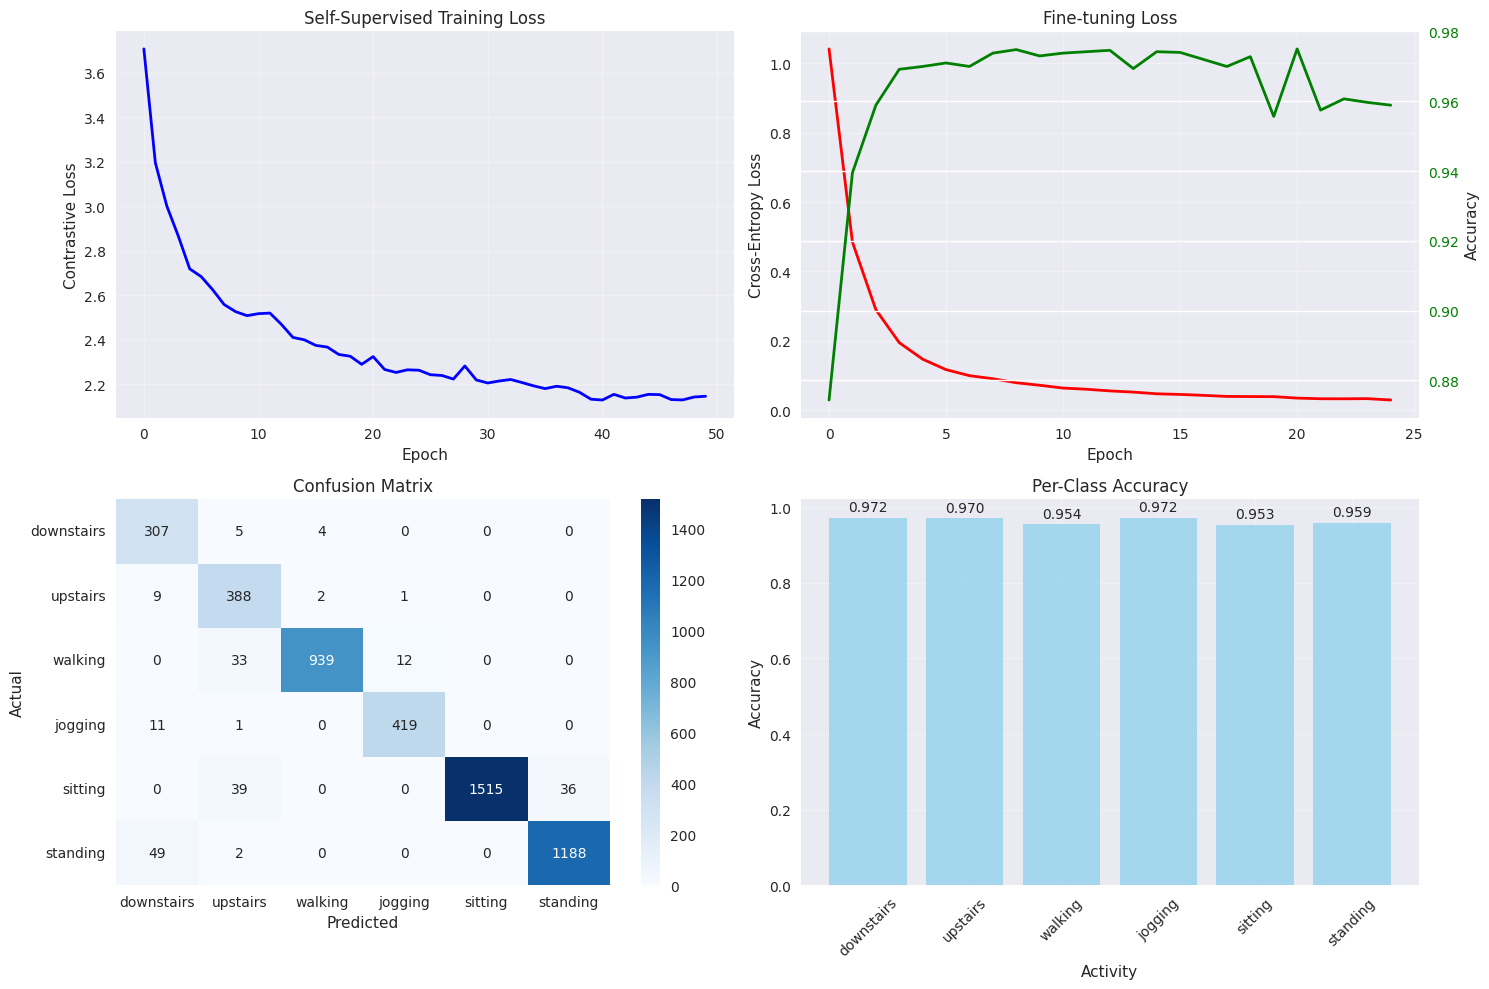

In [9]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Self-supervised training loss
axes[0, 0].plot(train_losses, 'b-', linewidth=2)
axes[0, 0].set_title('Self-Supervised Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Contrastive Loss')
axes[0, 0].grid(True, alpha=0.3)

# Fine-tuning loss and accuracy
axes[0, 1].plot(finetune_losses, 'r-', linewidth=2, label='Loss')
axes[0, 1].set_title('Fine-tuning Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Cross-Entropy Loss')
axes[0, 1].grid(True, alpha=0.3)

ax_acc = axes[0, 1].twinx()
ax_acc.plot(finetune_accuracies, 'g-', linewidth=2, label='Accuracy')
ax_acc.set_ylabel('Accuracy')
ax_acc.tick_params(axis='y', labelcolor='g')

# Confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=activity_names, yticklabels=activity_names, 
            ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# Per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
bars = axes[1, 1].bar(range(len(activity_names)), class_accuracies, 
                      color='skyblue', alpha=0.7)
axes[1, 1].set_title('Per-Class Accuracy')
axes[1, 1].set_xlabel('Activity')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_xticks(range(len(activity_names)))
axes[1, 1].set_xticklabels(activity_names, rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, class_accuracies):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Computing t-SNE visualization...


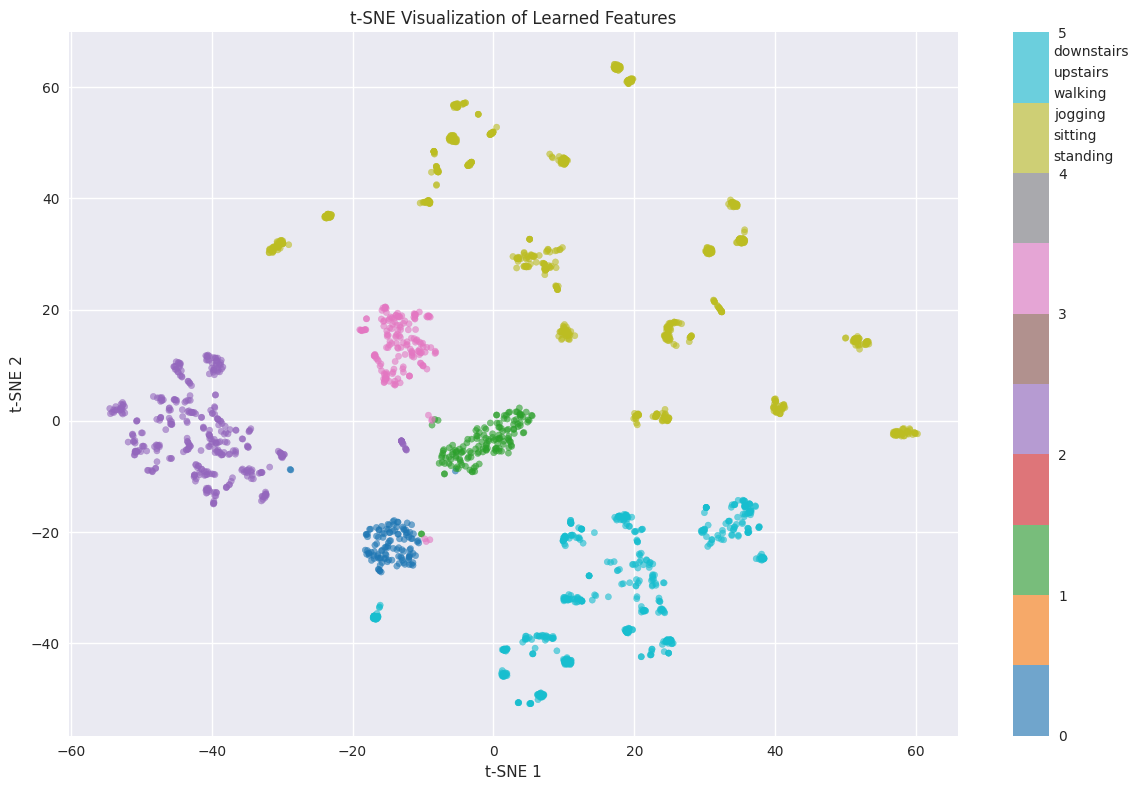

In [10]:
# t-SNE visualization of learned features
print("Computing t-SNE visualization...")

# Sample subset for faster computation
n_samples = min(2000, len(all_features))
indices = np.random.choice(len(all_features), n_samples, replace=False)

features_subset = all_features[indices]
labels_subset = np.array(all_labels)[indices]

# Compute t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(features_subset)

# Plot t-SNE
plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                     c=labels_subset, cmap='tab10', alpha=0.6, s=20)
plt.colorbar(scatter, ticks=range(len(activity_names)))
plt.title('t-SNE Visualization of Learned Features')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Add legend
handles = [plt.scatter([], [], c=plt.cm.tab10(i), label=activity_names[i], s=50) 
           for i in range(len(activity_names))]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## 7. Feature Analysis

Analyzing learned features...


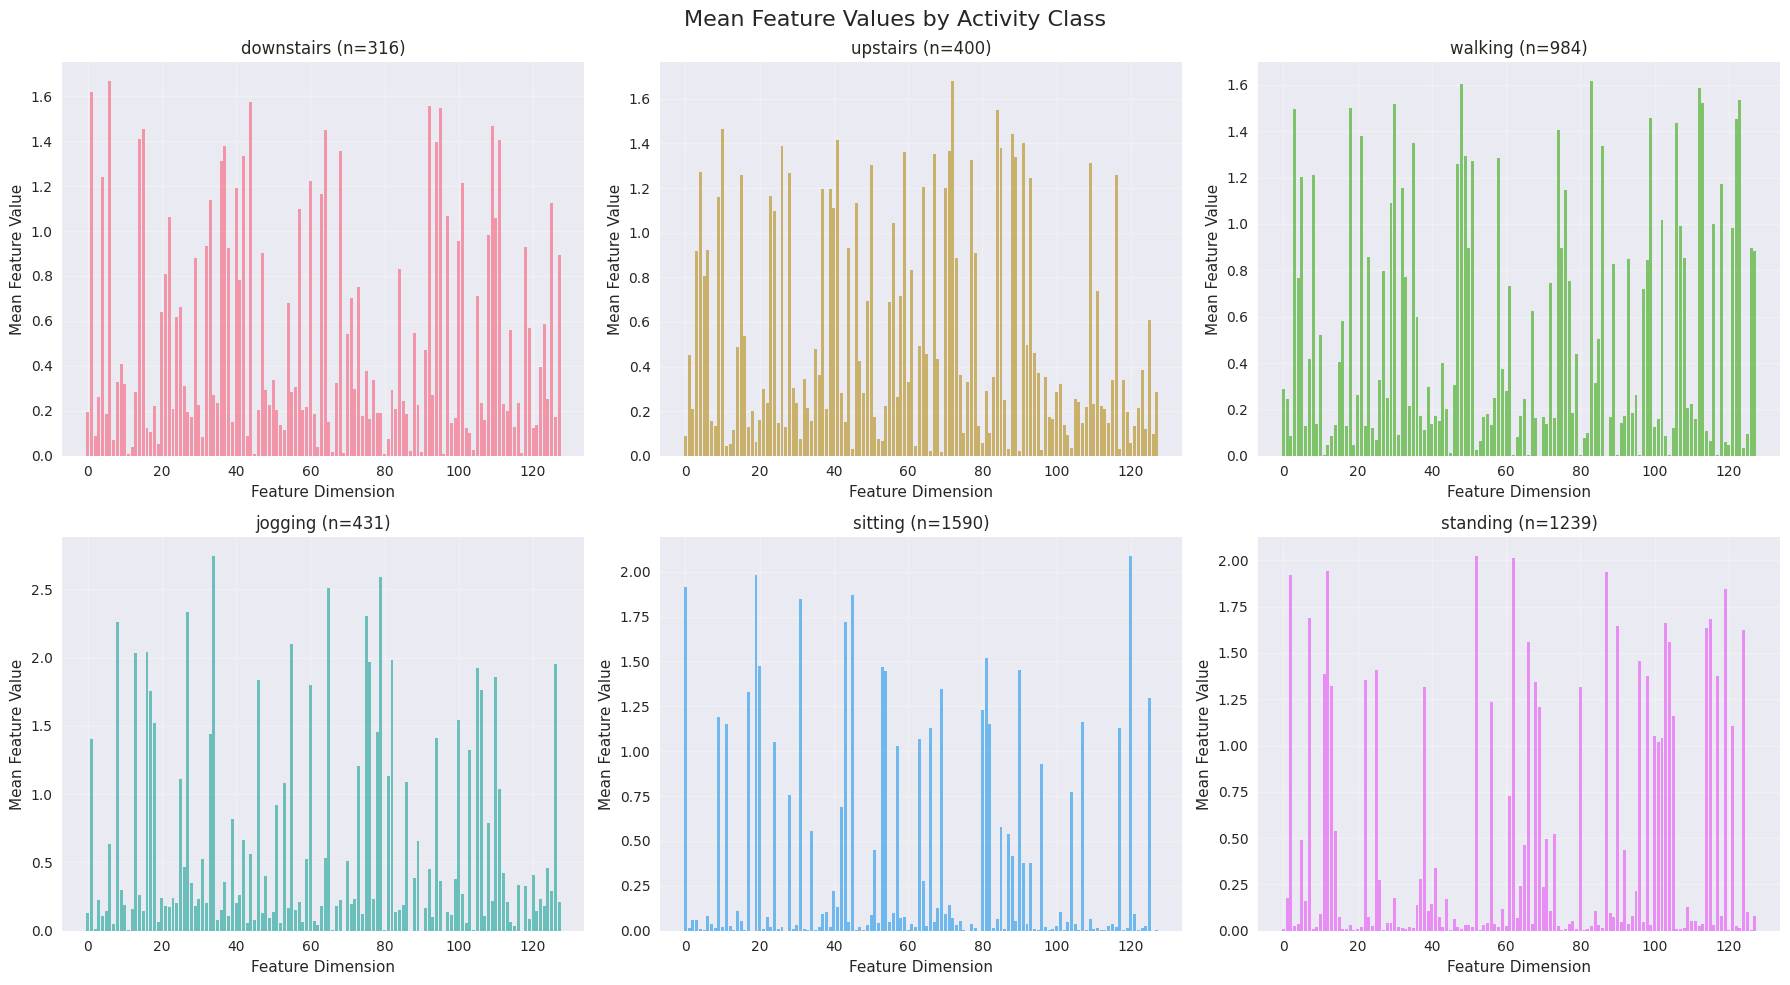

In [11]:
# Analyze learned features
print("Analyzing learned features...")

# Feature statistics by class
feature_stats = {}
for class_idx, class_name in enumerate(activity_names):
    class_mask = np.array(all_labels) == class_idx
    if np.sum(class_mask) > 0:
        class_features = all_features[class_mask]
        feature_stats[class_name] = {
            'mean': np.mean(class_features, axis=0),
            'std': np.std(class_features, axis=0),
            'samples': np.sum(class_mask)
        }

# Plot feature distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (class_name, stats) in enumerate(feature_stats.items()):
    if idx < 6:  # Only plot first 6 classes
        # Plot feature mean for each class
        axes[idx].bar(range(len(stats['mean'])), stats['mean'], 
                     alpha=0.7, color=f'C{idx}')
        axes[idx].set_title(f'{class_name} (n={stats["samples"]})')
        axes[idx].set_xlabel('Feature Dimension')
        axes[idx].set_ylabel('Mean Feature Value')
        axes[idx].grid(True, alpha=0.3)

plt.suptitle('Mean Feature Values by Activity Class', fontsize=16)
plt.tight_layout()
plt.show()

## 8. Model Saving

In [12]:
# Save the trained model
model_save_dir = '../checkpoints/'
os.makedirs(model_save_dir, exist_ok=True)

# Save model checkpoint
checkpoint = {
    'epoch': num_epochs + finetune_epochs,
    'model_state_dict': model.state_dict(),
    'temporal_model_state_dict': temporal_model.state_dict(),
    'optimizer_state_dict': finetune_optimizer.state_dict(),
    'loss': finetune_losses[-1],
    'accuracy': finetune_accuracies[-1],
    'config': {
        'input_channels': config.NUM_FEATURES,
        'num_classes': config.NUM_CLASSES,
        'window_size': config.WINDOW_SIZE
    }
}

model_path = os.path.join(model_save_dir, 'tstcc_motionsense_model.pth')
torch.save(checkpoint, model_path)

print(f"Model saved to: {model_path}")
print(f"Final test accuracy: {accuracy:.4f}")

# Save training history
training_history = {
    'pretraining_losses': train_losses,
    'finetuning_losses': finetune_losses,
    'finetuning_accuracies': finetune_accuracies,
    'test_accuracy': accuracy,
    'activity_names': activity_names
}

history_path = os.path.join(model_save_dir, 'tstcc_training_history.npy')
np.save(history_path, training_history)

print(f"Training history saved to: {history_path}")

Model saved to: ../checkpoints/tstcc_motionsense_model.pth
Final test accuracy: 0.9589
Training history saved to: ../checkpoints/tstcc_training_history.npy


## 9. Summary and Next Steps

In [13]:
print("TS-TCC Training Summary")
print("=" * 50)
print(f"Dataset: MotionSense")
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Test samples: {X_test.shape[0]:,}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Window size: {X_train.shape[2]}")
print(f"Number of classes: {len(activity_names)}")
print()
print(f"Model Configuration:")
print(f"- Input channels: {config.NUM_FEATURES}")
print(f"- Mid channels: 64")
print(f"- Final out channels: 128")
print(f"- Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print()
print(f"Training Configuration:")
print(f"- Self-supervised epochs: {num_epochs}")
print(f"- Fine-tuning epochs: {finetune_epochs}")
print(f"- Batch size: {batch_size}")
print(f"- Learning rate (pretraining): {learning_rate}")
print(f"- Learning rate (fine-tuning): {finetune_lr}")
print()
print(f"Results:")
print(f"- Final test accuracy: {accuracy:.4f}")
print(f"- Best class accuracy: {max(class_accuracies):.4f} ({activity_names[np.argmax(class_accuracies)]})")
print(f"- Worst class accuracy: {min(class_accuracies):.4f} ({activity_names[np.argmin(class_accuracies)]})")
print()
print("Next Steps:")
print("1. Try different augmentation strategies")
print("2. Experiment with different model architectures")
print("3. Compare with other self-supervised methods")
print("4. Test on PAMAP2 dataset")
print("5. Implement cross-dataset transfer learning")

TS-TCC Training Summary
Dataset: MotionSense
Training samples: 16,579
Test samples: 4,960
Number of features: 12
Window size: 128
Number of classes: 6

Model Configuration:
- Input channels: 12
- Mid channels: 64
- Final out channels: 128
- Total parameters: 105,990

Training Configuration:
- Self-supervised epochs: 50
- Fine-tuning epochs: 25
- Batch size: 64
- Learning rate (pretraining): 0.0003
- Learning rate (fine-tuning): 0.0001

Results:
- Final test accuracy: 0.9589
- Best class accuracy: 0.9722 (jogging)
- Worst class accuracy: 0.9528 (sitting)

Next Steps:
1. Try different augmentation strategies
2. Experiment with different model architectures
3. Compare with other self-supervised methods
4. Test on PAMAP2 dataset
5. Implement cross-dataset transfer learning
